In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.stats import mode
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
dataset = 1 # which dataset are we working on?
# Dataset 1
if dataset == 1:
    filename = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
    # filename = 'concentric_dataset.csv'
    data = pd.read_csv(filename)
# dataset 2
elif dataset == 2:
    train_df = pd.read_csv('adult.data', header=None)
    test_df = pd.read_csv('adult.test', header=None, skiprows=1) # first line skips
    # train_df = train_df.head(700) # debugging purpose
    # test_df = test_df.head(500)
    total_training_data = train_df.shape[0]
    total_test_data = test_df.shape[0]
    data = pd.concat([train_df, test_df], ignore_index=True) # combine them
elif dataset == 3:
    filename = 'concentric_dataset.csv'
    data = pd.read_csv(filename)

# scaling function
def scale_features(the_features, initial_feature, choice):
    feature_scaled = the_features.copy()
    # have to avoid scaling one-hot (dummy) columns
    one_hot_dummy_columns = feature_scaled.columns.difference(initial_feature)
    scaling_columns = feature_scaled.columns.difference(one_hot_dummy_columns)
    if choice == 0:
        scaler = StandardScaler()
        feature_scaled[scaling_columns] = scaler.fit_transform(the_features[scaling_columns])
    else:
        scaler = MinMaxScaler()
        feature_scaled[scaling_columns] = scaler.fit_transform(the_features[scaling_columns])
    return feature_scaled

# data preprocessing for log reg
def prep_data(data_main, target, dataset_no):
    data = data_main.copy()
    # for debugging purpose, later commented out
    data = data.head(1000)

    # common prep
    data.drop_duplicates(inplace=True) #drop duplicates and nulls
    # drop rows where target is null
    if dataset_no == 1 or 3:
        data.dropna(subset=[target], inplace=True)
    elif dataset_no == 2:
        data.dropna(subset=[data.columns[-1]], inplace=True)


    data.replace('?', np.nan, inplace=True) # Replacing '?' with NaN

    if dataset_no==1 or 3:
        data = data.drop(data.columns[0], axis=1) # drop the id as its not useful
    
    # common preprocessing of dataset
    if dataset_no == 1 or 3:
        x_data = data.drop(columns=[target])
        y_data = data[target]
    elif dataset_no == 2:
        target_column = data.columns[-1]
        x_data = data.drop(columns=[target_column])
        y_data = data.iloc[:, -1]

    init_feature = x_data.columns
    encoder = LabelEncoder()
    y_data = encoder.fit_transform(y_data) # target label encoding
    x_data = pd.get_dummies(x_data) # one-hot encoding
    x_data.fillna(x_data.mean(), inplace=True) # replace missing values with mean
    scaled_x_data = scale_features(x_data, init_feature, 1) # scaling features
    scaled_x_data = pd.DataFrame(scaled_x_data, columns=x_data.columns) # convert to dataset again
    x_data = scaled_x_data.astype(float)

    # splitting the data
    if dataset_no == 1 or 3:
        X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
    elif dataset_no == 2:
        # print(y_data.shape)
        X_train = x_data.head(total_training_data)
        X_test = x_data.tail(total_test_data)
        y_train = y_data[:total_training_data]
        y_test = y_data[-total_test_data:]
        # print(X_test.shape)
        # print(X_train.shape)

    return X_train, X_test, y_train, y_test

In [138]:
# get the data (here dataset will identify)
x_train, x_test, y_train, y_test = prep_data(data, 'Churn', dataset)

In [139]:
#LR implementation (x-nxm, y-1xm, w-nx1, dw-1xn, pred_y-1xm)
def lr_model(x, y, learn_rate, itn):
    x = x.values
    x = x.T # nxm order
    y = y.T # 1xm order
    m = x.shape[1] #no. of data
    n = x.shape[0] #no. of features
    w = np.zeros((n,1)) #initializing nx1 matrix
    b = 0

    for i in range(itn): 
        x_term = np.dot(w.T, x) + b
        y_pred = 1 / (1 + np.exp(-x_term)) #sigmoid func
        # error = -(1/m) * np.sum(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))
        # gradient descent
        dw = (1/m) * np.dot(y_pred - y, x.T)
        db = (1/m) * np.sum(y_pred - y)
        w = w - (learn_rate * dw.T)
        b = b - (learn_rate * db)
        # if(i % 100 == 0):
        #     print('error ', error)
        
    return w, b # after training, we get a good w, b

def test(x, w, b):
    x = x.values
    x = x.T
    x_term = np.dot(w.T, x) + b
    y_pred_values = 1 / (1 + np.exp(-x_term)) #sigmoid func
    y_pred = np.where(y_pred_values < 0.5, 0, 1)
    return y_pred



In [140]:
def accuracy(y_pred, y):
    return np.sum(y_pred==y)/y.shape[0]*100

def sensitivity(y_pred, y): # accuracy of positive class
    true_positive = np.sum((y == 1) & (y_pred == 1)) # where both are positive
    total_positive = np.sum(y == 1) # true_pos + false_neg
    return true_positive / total_positive * 100

def specificity(y_pred, y): # accuracy of negative class
    true_negative = np.sum((y == 0) & (y_pred == 0))
    total_negative = np.sum(y == 0) # true_neg + false_pos
    return true_negative / total_negative * 100

def precision(y_pred, y):
    true_positive = np.sum((y == 1) & (y_pred == 1))
    total_positive_predicted = np.sum(y_pred == 1)
    return true_positive / total_positive_predicted * 100

def f1_score(y_pred, y):
    return 2 * ((precision(y_pred, y) * sensitivity(y_pred, y)) / (precision(y_pred, y) + sensitivity(y_pred, y)))

def auroc(y_pred, y):
    true_pos_rate = sensitivity(y_pred, y)
    false_pos_rate = 1 - specificity(y_pred, y)
    auc = np.trapz(true_pos_rate, false_pos_rate)
    return auc

def aupr(y_pred, y):
    recall = sensitivity(y_pred, y)
    precision = precision(y_pred, y)
    aup = np.trapz(recall, precision)
    return aup


In [141]:
# split the training data for training and validation
x_training, x_validation, y_training, y_validation = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [142]:
# bagging --> 9 training datasets
training_testing_set = []
for i in range(9):
    training_testing_set.append(train_test_split(x_training, y_training, test_size=0.2))

base_models = []
itn = 2000
learning_rate = 0.2 # by trial and error with 1000 rows data. larger values minimizes error!
for i in range(9):
    # Access the first element from the list
    current_set = training_testing_set[i]
    curr_x_train, curr_x_test, curr_y_train, curr_y_test = current_set
    base_models.append(lr_model(curr_x_train, curr_y_train, learning_rate, itn)) # train

In [143]:
# testing the base learners
y_predicted_values = []
for i in range(9):
    current_model = base_models[i] # from base model list -> get the i-th model
    curr_w, curr_b = current_model
    y_predicted_values.append(test(x_test, curr_w, curr_b))

y_prediced_values_nparray = np.stack(y_predicted_values) # 2d array
# print(y_prediced_values_nparray.shape)

In [144]:
# avg performance metrices of the 9 base learners
accuracies = []
sensitivities = []
specificities = []
precisions = []
f1_scores = []
for i in range(9):
    y_pred_reshaped = y_prediced_values_nparray[i].reshape(-1)
    # print(y_pred_reshaped.shape)
    accuracies.append(accuracy(y_pred_reshaped, y_test))
    sensitivities.append(sensitivity(y_pred_reshaped, y_test))
    specificities.append(specificity(y_pred_reshaped, y_test))
    precisions.append(precision(y_pred_reshaped, y_test))
    f1_scores.append(f1_score(y_pred_reshaped, y_test))

# averaging them
avg_accuracy = np.mean(accuracies)
avg_sensitivity = np.mean(sensitivities)
avg_specificity = np.mean(specificities)
avg_precision = np.mean(precisions)
avg_f1_score = np.mean(f1_scores)

print(avg_accuracy)
print(avg_sensitivity)
print(avg_specificity)
print(avg_precision)
print(avg_f1_score)

# print(y_prediced_values_nparray[0].reshape(-1).shape)
# print(y_test.shape)

81.38888888888889
54.732510288065846
91.24809741248097
70.02316542427073
61.29740564308333


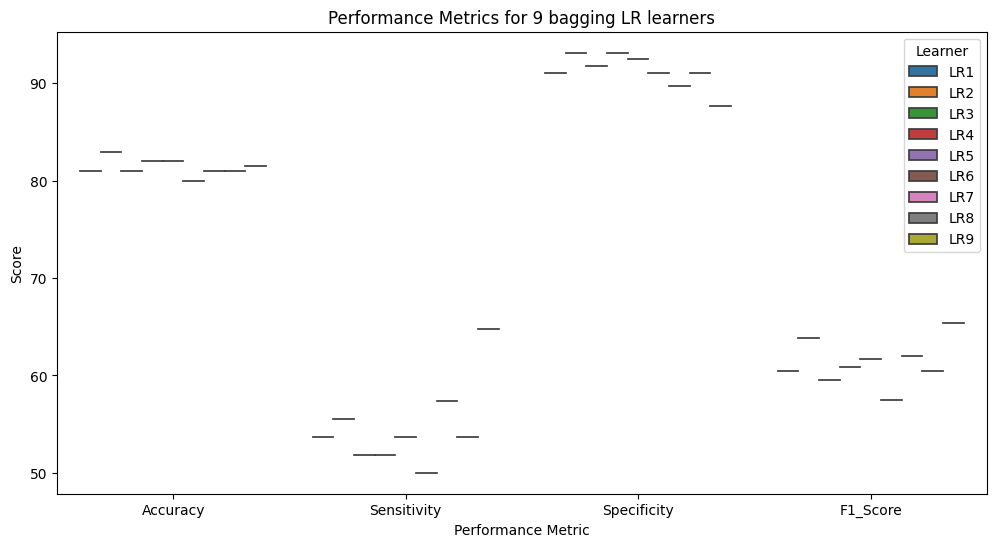

In [145]:
# draw violin plots for each of the metrices

data_bagging = {
    'Learner': ['LR1', 'LR2', 'LR3', 'LR4', 'LR5', 'LR6', 'LR7', 'LR8', 'LR9'],
    'Accuracy': accuracies,
    'Sensitivity': sensitivities,
    'Specificity': specificities,
    'F1_Score': f1_scores
}
df_bagging = pd.DataFrame(data_bagging)

# Melt the DataFrame to long format for easier plotting
df_melted_bagging = df_bagging.melt(id_vars='Learner', var_name='Metric', value_name='Score')
plt.figure(figsize=(12, 6))

# Create the violin plot
sns.violinplot(x='Metric', y='Score', hue='Learner', data=df_melted_bagging, split=True)

# Add titles and labels
plt.title('Performance Metrics for 9 bagging LR learners')
plt.xlabel('Performance Metric')
plt.ylabel('Score')

# Show the plot
plt.show()

In [147]:
# majority voting in column
y_majority_vote = mode(y_prediced_values_nparray, axis=0)[0]
y_majority_vote = y_majority_vote.flatten() # converts to 1d array
# print(y_majority_vote.shape)
# print(y_test.shape)
# ensemble voting performance metrics
ensemble_accuracy = accuracy(y_majority_vote, y_test)
ensemble_sensitivity = sensitivity(y_majority_vote, y_test)
ensemble_specificity = specificity(y_majority_vote, y_test)
ensemble_precision = precision(y_majority_vote, y_test)
ensemble_f1score = f1_score(y_majority_vote, y_test)
# ensemble_auroc = auroc(y_majority_vote, y_test)
# ensemble_aupr = aupr(y_majority_vote, y_test)

print(ensemble_accuracy)
print(ensemble_sensitivity)
print(ensemble_specificity)
print(ensemble_precision)
print(ensemble_f1score)
# print(ensemble_auroc)
# print(ensemble_aupr)


82.0
55.55555555555556
91.78082191780823
71.42857142857143
62.50000000000001


In [148]:
# Stacking starts here

# test the base models with validation set and extend validation set
validation_y_pred = []
x_validation_extended = x_validation.copy()
for i in range(9):
    curr_model = base_models[i]
    curr_model__w, curr_model_b = curr_model
    validation_y_pred.append(test(x_validation, curr_model__w, curr_model_b))
    x_validation_extended = np.hstack((x_validation_extended, validation_y_pred[i].T))
# print(x_validation.shape)
# print(validation_y_pred[i].T.shape) # total 9 models so adding 9 more columns
# print(x_validation_extended.shape)


In [149]:
# meta model training on this extended validation
x_validation_extended_dataframe = df = pd.DataFrame(x_validation_extended)
meta_model = lr_model(x_validation_extended_dataframe, y_validation, 0.8, 20000)

# extending test set with base models
y_pred_for_test_set = []
x_test_extended = x_test.copy()
for i in range(9):
    curr_model = base_models[i]
    curr_model_w, curr_model_b = curr_model
    y_pred_for_test_set.append(test(x_test, curr_model_w, curr_model_b))
    x_test_extended = np.hstack((x_test_extended, y_pred_for_test_set[i].T))

# print(x_test.shape)
# print(y_pred_for_test_set[i].T.shape)
# print(x_test_extended.shape)


In [150]:
# test the meta lr model on extended test set
meta_model_w, meta_model_b = meta_model
x_test_extended_dataframe = pd.DataFrame(x_test_extended)
y_pred_meta_model = test(x_test_extended_dataframe, meta_model_w, meta_model_b)


In [151]:
# performance metrices from stacking (meta model)
y_pred_meta_model_reshaped = y_pred_meta_model.reshape(-1)
# print(y_test.shape)
# print(y_pred_meta_model_reshaped.shape)
stacking_accuracy = accuracy(y_pred_meta_model_reshaped, y_test)
stacking_sensitivity = sensitivity(y_pred_meta_model_reshaped, y_test)
stacking_specificity = specificity(y_pred_meta_model_reshaped, y_test)
stacking_precision = precision(y_pred_meta_model_reshaped, y_test)
stacking_f1_score = f1_score(y_pred_meta_model_reshaped, y_test)

print(stacking_accuracy)
print(stacking_sensitivity)
print(stacking_specificity)
print(stacking_precision)
print(stacking_f1_score)

78.5
51.85185185185185
88.35616438356165
62.22222222222222
56.56565656565656


In [152]:
# comparative analysis table
data_table = {
    'Method': ['LR', 'Voting ensemble', 'Stacking ensemble'],
    'Accuracy': [avg_accuracy, ensemble_accuracy, stacking_accuracy],
    'Sensitivity': [avg_sensitivity, ensemble_sensitivity, stacking_sensitivity],
    'Specificity': [avg_specificity, ensemble_specificity, stacking_specificity],
    'F1_Score': [avg_f1_score, ensemble_f1score, stacking_f1_score]
}
# Create DataFrame
df_comparative = pd.DataFrame(data_table)
# display table
df_comparative

,Method,Accuracy,Sensitivity,Specificity,F1_Score
0,LR,81.388889,54.732510,91.248097,61.297406
1,Voting ensemble,82.000000,55.555556,91.780822,62.500000
2,Stacking ensemble,78.500000,51.851852,88.356164,56.565657
